# Phân tích và dự đoán ô nhiễm không khí ở NewYork.

## 1. Đọc và khám phá dữ liệu

In [212]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, month, dayofmonth, quarter, dayofweek, weekofyear, col , floor, lag, avg, stddev, max, min, isnan, udf, concat, lit , when, count, sum, round, desc, asc, rank, dense_rank, collect_list, collect_set, countDistinct, approx_count_distinct, first, last, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.sql.types import IntegerType
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("AirQualityAnalysis").getOrCreate()

# Kiểm tra SparkContext đã được khởi tạo chưa
print(spark)
# Đọc file CSV
file_path = "D:/Kỳ 2_ 2024-2025/BigData/LAB/Project/btl_Nhom10/Air_Quality.csv" 
df = spark.read.csv(file_path, header=True, inferSchema=True)


In [213]:
# Hiển thị thông tin dữ liệu
df.show(5)  # Hiển thị 5 dòng đầu tiên

+---------+------------+--------------------+-------+------------+-------------+-----------+--------------------+-------------------+----------+----------+-------+
|Unique ID|Indicator ID|                Name|Measure|Measure Info|Geo Type Name|Geo Join ID|      Geo Place Name|        Time Period|Start_Date|Data Value|Message|
+---------+------------+--------------------+-------+------------+-------------+-----------+--------------------+-------------------+----------+----------+-------+
|   172653|         375|Nitrogen dioxide ...|   Mean|         ppb|        UHF34|        203|Bedford Stuyvesan...|Annual Average 2011|12/01/2010|      25.3|   NULL|
|   172585|         375|Nitrogen dioxide ...|   Mean|         ppb|        UHF34|        203|Bedford Stuyvesan...|Annual Average 2009|12/01/2008|     26.93|   NULL|
|   336637|         375|Nitrogen dioxide ...|   Mean|         ppb|        UHF34|        204|       East New York|Annual Average 2015|01/01/2015|     19.09|   NULL|
|   336622|     

In [214]:
df.count()  # Đếm số dòng trong DataFrame

16218

## 2. Tiền xử lý dữ liệu

### b1. xử lý giá trị thiếu

In [215]:
# Đọc và chọn các cột quan trọng từ dữ liệu
df = df.select(
    col("Time Period").cast("double"),
    col("Data Value").cast("double").alias("label"),
    # Giữ lại các cột khác cần cho trực quan hóa:
    col("Name"),
    col("Geo Type Name"),
    col("Measure"),
    col("Geo Place Name")
)

In [216]:
# Kiểm tra schema để xem tên cột chính xác
df.printSchema()

root
 |-- Time Period: double (nullable = true)
 |-- label: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Geo Type Name: string (nullable = true)
 |-- Measure: string (nullable = true)
 |-- Geo Place Name: string (nullable = true)



In [217]:
# Loại bỏ giá trị thiếu
df = df.dropna()

In [219]:
# Kiểm tra và loại bỏ các dòng dữ liệu trùng lặp
print("Số lượng dòng ban đầu:", df.count())

# Loại bỏ các dòng trùng lặp hoàn toàn
df_unique = df.dropDuplicates()
print("Số lượng dòng sau khi loại bỏ trùng lặp hoàn toàn:", df_unique.count())

# Loại bỏ các dòng trùng lặp dựa trên một số cột cụ thể
df_unique_selective = df.dropDuplicates(subset=['Time Period', 'Name', 'Geo Place Name'])
print("Số lượng dòng sau khi loại bỏ trùng lặp theo các cột cụ thể:", df_unique_selective.count())

# Phân tích chi tiết các dòng trùng lặp
duplicate_count = df.groupBy('Time Period', 'Name', 'Geo Place Name') \
    .count() \
    .filter(col('count') > 1) \
    .orderBy('count', ascending=False)

Số lượng dòng ban đầu: 1326
Số lượng dòng sau khi loại bỏ trùng lặp hoàn toàn: 1326
Số lượng dòng sau khi loại bỏ trùng lặp theo các cột cụ thể: 1326


In [220]:
# Kiểm tra giá trị của Time Period
df.select("Time Period").show(5)

# Nếu Time Period là số năm (vd: 2018, 2019, 2020...)
df = df.withColumn("Year", col("Time Period").cast("integer"))

# Hoặc nếu Time Period có dạng YYYY.Q (ví dụ: 2018.1, 2018.2, 2018.3, 2018.4)
df = df.withColumn("Year", floor(col("Time Period")).cast("integer"))
df = df.withColumn("Quarter_Decimal", col("Time Period") - col("Year"))
df = df.withColumn("Quarter", (col("Quarter_Decimal") * 4 + 1).cast("integer"))

+-----------+
|Time Period|
+-----------+
|     2016.0|
|     2005.0|
|     2016.0|
|     2016.0|
|     2005.0|
+-----------+
only showing top 5 rows



In [172]:
# Đếm số giá trị null hoặc NaN trong mỗi cột
def count_nulls(df):
    for c in df.columns:
        null_count = df.filter(col(c).isNull() | isnan(col(c))).count()
        total_count = df.count()
        if total_count > 0:
            percent = null_count * 100.0 / total_count
            print(f"Cột '{c}': {null_count} giá trị null ({percent:.2f}%)")


In [173]:
count_nulls(df)

Cột 'Time Period': 0 giá trị null (0.00%)
Cột 'label': 0 giá trị null (0.00%)
Cột 'Name': 0 giá trị null (0.00%)
Cột 'Geo Type Name': 0 giá trị null (0.00%)
Cột 'Measure': 0 giá trị null (0.00%)
Cột 'Geo Place Name': 0 giá trị null (0.00%)
Cột 'Year': 0 giá trị null (0.00%)
Cột 'Quarter_Decimal': 0 giá trị null (0.00%)
Cột 'Quarter': 0 giá trị null (0.00%)


In [174]:
df.show(10)  # Hiển thị 1010 dòng đầu tiên

+-----------+-----+--------------------+-------------+-------------+--------------------+----+---------------+-------+
|Time Period|label|                Name|Geo Type Name|      Measure|      Geo Place Name|Year|Quarter_Decimal|Quarter|
+-----------+-----+--------------------+-------------+-------------+--------------------+----+---------------+-------+
|     2016.0| 26.1|Annual vehicle mi...|        UHF42|million miles|         Sunset Park|2016|            0.0|      1|
|     2005.0| 23.8|Annual vehicle mi...|        UHF42|million miles|  Fordham - Bronx Pk|2005|            0.0|      1|
|     2016.0| 36.4|Annual vehicle mi...|        UHF42|million miles|    Crotona -Tremont|2016|            0.0|      1|
|     2016.0| 53.5|Annual vehicle mi...|           CD|million miles|Clinton and Chels...|2016|            0.0|      1|
|     2005.0| 37.9|Annual vehicle mi...|           CD|million miles|Belmont and East ...|2005|            0.0|      1|
|     2016.0| 16.7|Annual vehicle mi...|        

In [175]:
df_pd = df.toPandas()

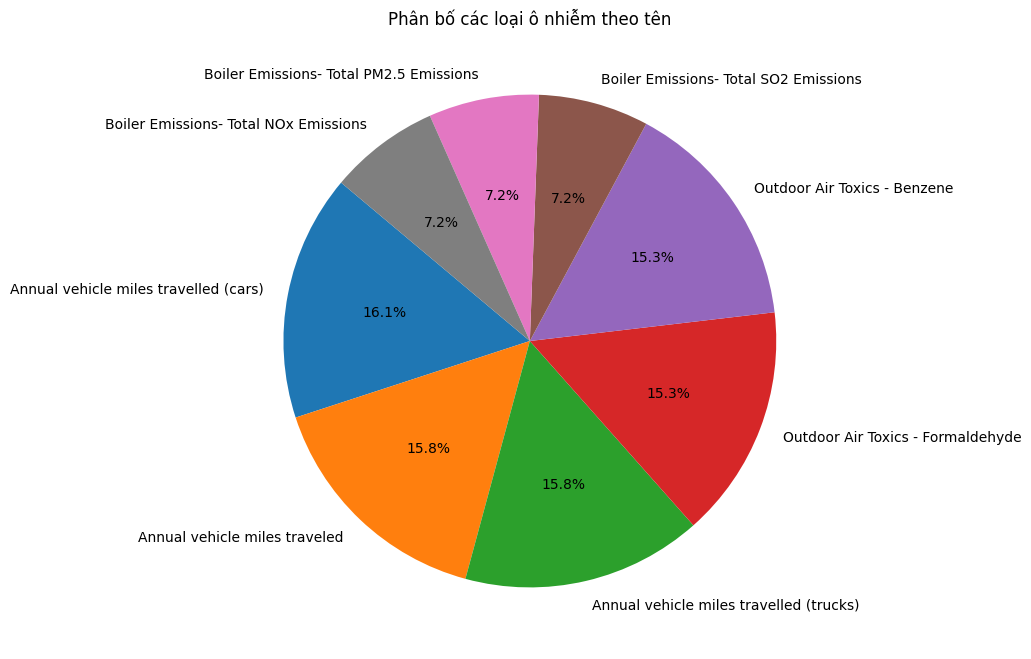

In [176]:
# --- 1. Biểu đồ tròn: Phân bố các loại ô nhiễm theo cột "Name" ---
plt.figure(figsize=(8,8))
name_counts = df_pd['Name'].value_counts()
plt.pie(name_counts, labels=name_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Phân bố các loại ô nhiễm theo tên')
plt.show()

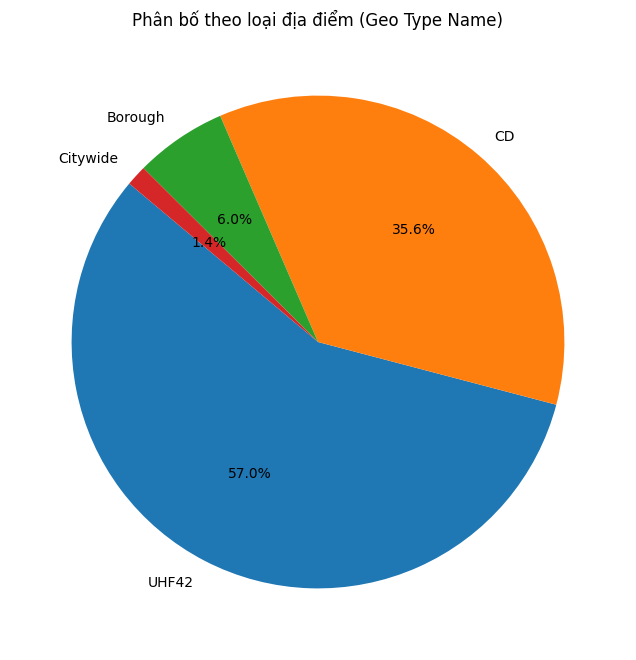

In [177]:
# --- 2. Biểu đồ tròn: Phân bố theo loại địa điểm (Geo Type Name) ---
plt.figure(figsize=(8,8))
geo_counts = df_pd['Geo Type Name'].value_counts()
plt.pie(geo_counts, labels=geo_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Phân bố theo loại địa điểm (Geo Type Name)')
plt.show()

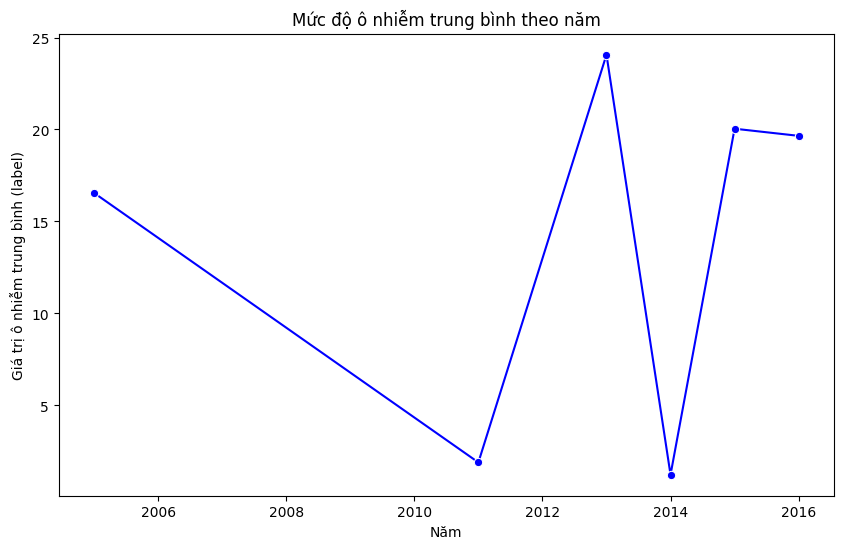

In [178]:
# --- 3. Biểu đồ đường: Mức độ ô nhiễm trung bình theo năm ---
# Trích xuất năm từ cột "Time Period" và tính trung bình theo năm
df_pd['Year'] = df_pd['Time Period'].astype(str).str.extract(r'(\d{4})').astype(float)
avg_pollution_by_year = df_pd.groupby('Year')['label'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='label', data=avg_pollution_by_year, marker='o', color='blue')
plt.title('Mức độ ô nhiễm trung bình theo năm')
plt.xlabel('Năm')
plt.ylabel('Giá trị ô nhiễm trung bình (label)')
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16196\2190510585.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Measure', data=df_pd, order=df_pd['Measure'].value_counts().index, palette="Set2")


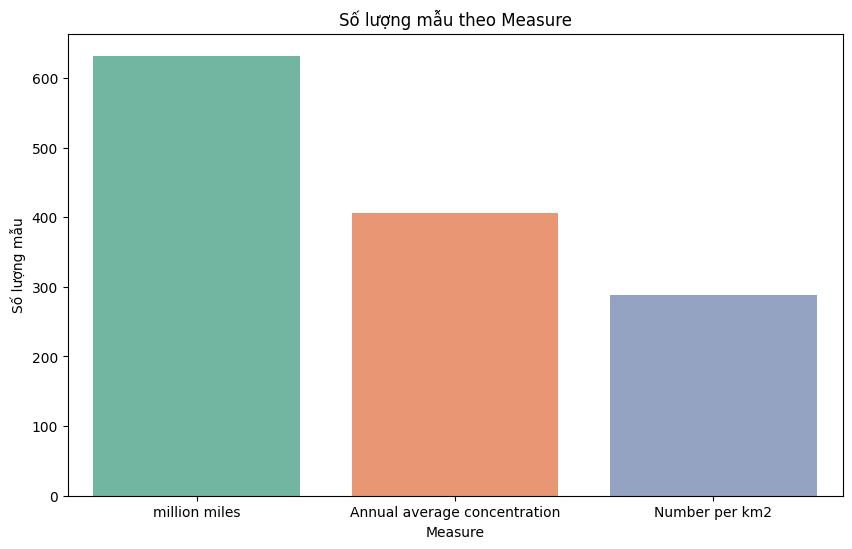

In [179]:
# --- 4. Biểu đồ cột: Số lượng mẫu theo Measure ---
plt.figure(figsize=(10,6))
sns.countplot(x='Measure', data=df_pd, order=df_pd['Measure'].value_counts().index, palette="Set2")
plt.title('Số lượng mẫu theo Measure')
plt.xlabel('Measure')
plt.ylabel('Số lượng mẫu')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16196\3527406517.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='Geo Place Name', data=avg_pollution_by_geo, palette="viridis")


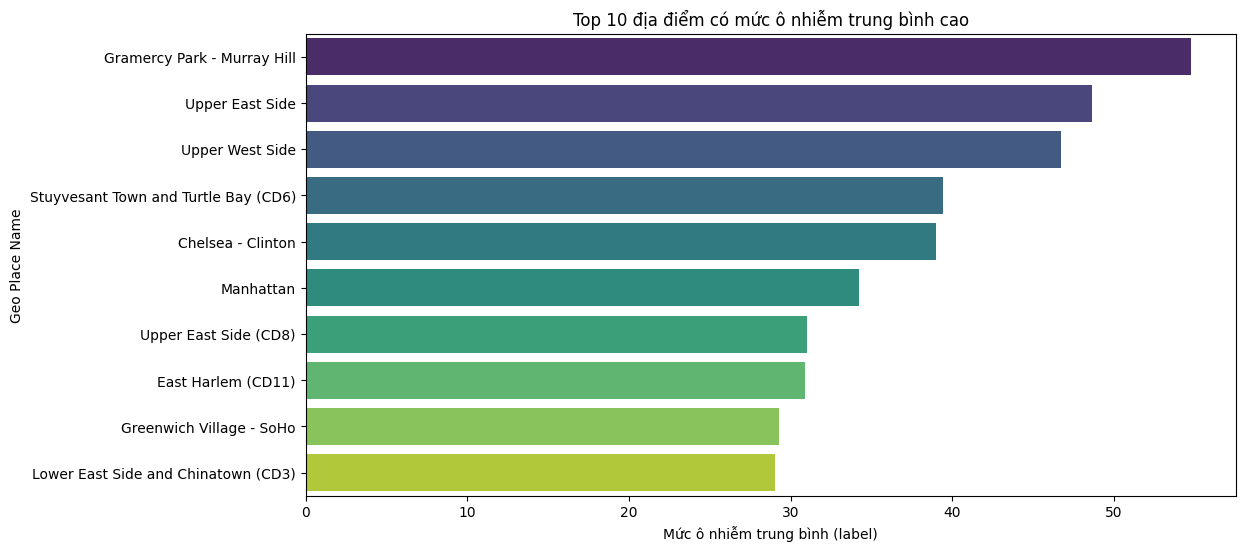

In [180]:
# --- 5. Biểu đồ cột: Top 10 địa điểm có mức ô nhiễm trung bình cao ---
plt.figure(figsize=(12,6))
avg_pollution_by_geo = df_pd.groupby('Geo Place Name')['label'].mean().sort_values(ascending=False).head(10).reset_index()
sns.barplot(x='label', y='Geo Place Name', data=avg_pollution_by_geo, palette="viridis")
plt.title('Top 10 địa điểm có mức ô nhiễm trung bình cao')
plt.xlabel('Mức ô nhiễm trung bình (label)')
plt.ylabel('Geo Place Name')
plt.show()

### b2. Chuẩn hóa - tạo đặc trưng

In [181]:
def advanced_feature_engineering(df):
    # Trích xuất thêm các đặc trưng chi tiết
    df = df.withColumn("Year", year(col("Time Period").cast("timestamp")))
    df = df.withColumn("Month", month(col("Time Period").cast("timestamp")))
    df = df.withColumn("Quarter", quarter(col("Time Period").cast("timestamp")))
    
    # Tạo các đặc trưng tương tác
    df = df.withColumn("Year_Name_Interaction", 
        concat(col("Year").cast("string"), lit("_"), col("Name"))
    )
    
    # Tạo nhóm theo địa điểm
    df = df.withColumn("Geo_Group", 
        when(col("Geo Place Name").like("%Brooklyn%"), "Brooklyn")
        .when(col("Geo Place Name").like("%Manhattan%"), "Manhattan")
        .otherwise("Other")
    )
    
    # Các cột phân loại để mã hóa
    categorical_cols = ["Name", "Measure", "Geo Place Name", "Geo_Group", "Year_Name_Interaction"]
    
    # Giai đoạn xử lý đặc trưng
    stages = []
    
    # StringIndexer cho các cột phân loại
    for cat_col in categorical_cols:
        indexer = StringIndexer(
            inputCol=cat_col, 
            outputCol=f"{cat_col}_index", 
            handleInvalid="keep"
        )
        stages.append(indexer)
    
    # OneHotEncoder
    for cat_col in categorical_cols:
        encoder = OneHotEncoder(
            inputCol=f"{cat_col}_index", 
            outputCol=f"{cat_col}_encoded"
        )
        stages.append(encoder)
    
    # Các cột số học
    numeric_cols = [
        "Time Period", "Year", "Month", "Quarter", 
        "label"  # Giữ nguyên label
    ]
    
    # Tập hợp các đặc trưng số
    assembler_numeric = VectorAssembler(
        inputCols=numeric_cols, 
        outputCol="numeric_features"
    )
    stages.append(assembler_numeric)
    
    # Chuẩn hóa các đặc trưng số
    scaler = StandardScaler(
        inputCol="numeric_features", 
        outputCol="scaled_numeric_features", 
        withStd=True, 
        withMean=True
    )
    stages.append(scaler)
    
    # Tập hợp tất cả các đặc trưng
    final_assembler = VectorAssembler(
        inputCols=[f"{col}_encoded" for col in categorical_cols] + ["scaled_numeric_features"],
        outputCol="features"
    )
    stages.append(final_assembler)
    
    # Tạo Pipeline
    pipeline = Pipeline(stages=stages)
    
    # Áp dụng Pipeline
    model = pipeline.fit(df)
    transformed_df = model.transform(df)
    
    return transformed_df

# Áp dụng kỹ thuật xử lý đặc trưng nâng cao
df_transformed = advanced_feature_engineering(df)

In [182]:
# VectorAssembler
feature_cols = ["Time Period"]
target_col = "label"
df = df.withColumn("Time Period", col("Time Period").cast("double"))
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_transformed = assembler.transform(df).select("features", target_col)
df_transformed.show(10)

+--------+-----+
|features|label|
+--------+-----+
|[2016.0]| 26.1|
|[2005.0]| 23.8|
|[2016.0]| 36.4|
|[2016.0]| 53.5|
|[2005.0]| 37.9|
|[2016.0]| 16.7|
|[2005.0]| 53.1|
|[2016.0]| 59.7|
|[2016.0]| 44.9|
|[2005.0]| 36.5|
+--------+-----+
only showing top 10 rows



In [183]:
# lọc điều kiện
df_filtered = df.where(col("Data Value") > 40)
df_filtered.show(5)

+-----------+-----+--------------------+-------------+-------------+--------------------+----+---------------+-------+
|Time Period|label|                Name|Geo Type Name|      Measure|      Geo Place Name|Year|Quarter_Decimal|Quarter|
+-----------+-----+--------------------+-------------+-------------+--------------------+----+---------------+-------+
|     2016.0| 53.5|Annual vehicle mi...|           CD|million miles|Clinton and Chels...|2016|            0.0|      1|
|     2005.0| 53.1|Annual vehicle mi...|        UHF42|million miles|         East Harlem|2005|            0.0|      1|
|     2016.0| 59.7|Annual vehicle mi...|        UHF42|million miles|         East Harlem|2016|            0.0|      1|
|     2016.0| 44.9|Annual vehicle mi...|           CD|million miles|Rego Park and For...|2016|            0.0|      1|
|     2005.0| 45.7|Annual vehicle mi...|           CD|million miles|Greenwich Village...|2005|            0.0|      1|
+-----------+-----+--------------------+--------

### b3. Chia tập dữ liệu thành train và test

In [184]:
# Chia dữ liệu thành 80% train và 20% test
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Tính toán IQR và giới hạn để loại bỏ ngoại lai
Q1 = df_transformed.approxQuantile("label", [0.25], 0.0)[0]
Q3 = df_transformed.approxQuantile("label", [0.75], 0.0)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc bỏ ngoại lai
train_data_cleaned = train_data.filter(
    (col("label") >= lower_bound) & 
    (col("label") <= upper_bound)
)

test_data_cleaned = test_data.filter(
    (col("label") >= lower_bound) & 
    (col("label") <= upper_bound)
)

# Kiểm tra kích thước của tập train và test sau khi loại bỏ ngoại lai
print(f"Số dòng trong tập train gốc: {train_data.count()}")
print(f"Số dòng trong tập train sau khi loại bỏ ngoại lai: {train_data_cleaned.count()}")
print(f"Số dòng trong tập test gốc: {test_data.count()}")
print(f"Số dòng trong tập test sau khi loại bỏ ngoại lai: {test_data_cleaned.count()}")

Số dòng trong tập train gốc: 1099
Số dòng trong tập train sau khi loại bỏ ngoại lai: 1057
Số dòng trong tập test gốc: 227
Số dòng trong tập test sau khi loại bỏ ngoại lai: 219


In [185]:
train_data.show(5)
test_data.show(5)

+--------+-----+
|features|label|
+--------+-----+
|[2005.0]|  0.2|
|[2005.0]|  0.2|
|[2005.0]|  0.3|
|[2005.0]|  0.4|
|[2005.0]|  0.4|
+--------+-----+
only showing top 5 rows

+--------+-----+
|features|label|
+--------+-----+
|[2005.0]|  0.3|
|[2005.0]|  0.4|
|[2005.0]|  0.5|
|[2005.0]|  0.6|
|[2005.0]|  0.7|
+--------+-----+
only showing top 5 rows



### b4. Tạo và áp dụng pipeline

In [186]:
# Bắt đầu với pipeline đơn giản nhất
# Chỉ sử dụng các cột số học
numeric_cols = ["TimePeriod", "GeoJoinID"]

# VectorAssembler cho các cột số học
simple_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

# Pipeline đơn giản
simple_pipeline = Pipeline(stages=[simple_assembler])

# Áp dụng pipeline đơn giản
try:
    simple_transformed = simple_pipeline.fit(df).transform(df)
    print("Pipeline đơn giản thành công!")
    simple_transformed.select("features").show(5)
except Exception as e:
    print("Lỗi trong pipeline đơn giản:", e)

Lỗi trong pipeline đơn giản: TimePeriod does not exist. Available: Time Period, label, Name, Geo Type Name, Measure, Geo Place Name, Year, Quarter_Decimal, Quarter


In [187]:
# Kiểm tra từng cột phân loại
for cat_col in ["Name", "Measure", "MeasureInfo", "GeoTypeName", "GeoPlaceName"]:
    try:
        # Kiểm tra cột tồn tại
        df.select(cat_col).show(1)
        print(f"Cột {cat_col} OK!")
        
        # Thử StringIndexer
        indexer = StringIndexer(inputCol=cat_col, outputCol=cat_col+"Index", handleInvalid="keep")
        indexed = indexer.fit(df).transform(df)
        indexed.select(cat_col, cat_col+"Index").show(2)
        print(f"StringIndexer cho {cat_col} OK!")
        
        # Thử OneHotEncoder
        encoder = OneHotEncoder(inputCol=cat_col+"Index", outputCol=cat_col+"Vec")
        encoded = encoder.transform(indexed)
        encoded.select(cat_col+"Index", cat_col+"Vec").show(2)
        print(f"OneHotEncoder cho {cat_col} OK!")
        
        print(f"Cột {cat_col} đã qua kiểm tra hoàn chỉnh!\n")
    except Exception as e:
        print(f"Lỗi khi xử lý cột {cat_col}:", e)
        print()

+--------------------+
|                Name|
+--------------------+
|Annual vehicle mi...|
+--------------------+
only showing top 1 row

Cột Name OK!
+--------------------+---------+
|                Name|NameIndex|
+--------------------+---------+
|Annual vehicle mi...|      1.0|
|Annual vehicle mi...|      1.0|
+--------------------+---------+
only showing top 2 rows

StringIndexer cho Name OK!
Lỗi khi xử lý cột Name: 'OneHotEncoder' object has no attribute 'transform'

+-------------+
|      Measure|
+-------------+
|million miles|
+-------------+
only showing top 1 row

Cột Measure OK!
+-------------+------------+
|      Measure|MeasureIndex|
+-------------+------------+
|million miles|         0.0|
|million miles|         0.0|
+-------------+------------+
only showing top 2 rows

StringIndexer cho Measure OK!
Lỗi khi xử lý cột Measure: 'OneHotEncoder' object has no attribute 'transform'

Lỗi khi xử lý cột MeasureInfo: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function para

In [188]:
# Tạo Pipeline đơn giản
simple_pipeline = Pipeline(stages=[assembler])

In [189]:
# Áp dụng Pipeline
transformed_df = simple_pipeline.fit(df).transform(df)
transformed_df.select("Time Period", "features", "label").show(5)

+-----------+--------+-----+
|Time Period|features|label|
+-----------+--------+-----+
|     2016.0|[2016.0]| 26.1|
|     2005.0|[2005.0]| 23.8|
|     2016.0|[2016.0]| 36.4|
|     2016.0|[2016.0]| 53.5|
|     2005.0|[2005.0]| 37.9|
+-----------+--------+-----+
only showing top 5 rows



## 3. Huấn luyện mô hình hồi quy tuyến tính

### b1. Huấn luyện mô hình hồi quy tuyến tính

In [190]:

# Khởi tạo mô hình hồi quy tuyến tính
lr = LinearRegression(featuresCol="features", labelCol="label")

# Huấn luyện mô hình trên tập train
model = lr.fit(train_data)

# In ra các hệ số và intercept
print("Hệ số (Coefficients):", model.coefficients)
print("Hằng số (Intercept):", model.intercept)

# Dự đoán trên tập test
predictions = model.transform(test_data)

# Hiển thị một vài dự đoán
predictions.select("features", "label", "prediction").show(10)

# Đánh giá mô hình trên tập train (hoặc bạn có thể đánh giá trên tập test với evaluator riêng)
training_summary = model.summary
print("RMSE trên tập train:", training_summary.rootMeanSquaredError)
print("R2 trên tập train:", training_summary.r2)


Hệ số (Coefficients): [0.14762196481944762]
Hằng số (Intercept): -281.6553469323078
+--------+-----+------------------+
|features|label|        prediction|
+--------+-----+------------------+
|[2005.0]|  0.3|14.326692530684682|
|[2005.0]|  0.4|14.326692530684682|
|[2005.0]|  0.5|14.326692530684682|
|[2005.0]|  0.6|14.326692530684682|
|[2005.0]|  0.7|14.326692530684682|
|[2005.0]|  0.8|14.326692530684682|
|[2005.0]|  0.9|14.326692530684682|
|[2005.0]|  1.1|14.326692530684682|
|[2005.0]|  1.3|14.326692530684682|
|[2005.0]|  1.3|14.326692530684682|
+--------+-----+------------------+
only showing top 10 rows

RMSE trên tập train: 26.035234010027153
R2 trên tập train: 0.0006457041238784322


### b2. Chuyển Spark DataFrame sang Pandas để tính toán thống kê & vẽ biểu đồ

In [191]:
# Chuyển đổi DataFrame dự đoán sang Pandas
predictions_pd = predictions.select("features", "label", "prediction").toPandas()

# Vì "features" là vector (ở đây chỉ có 1 phần tử là Time Period), ta trích xuất giá trị đó
predictions_pd['Time_Period'] = predictions_pd['features'].apply(lambda x: x[0] if x is not None and len(x) > 0 else None)

# Tính sai số (residual): giá trị thực - giá trị dự đoán
predictions_pd['residual'] = predictions_pd['label'] - predictions_pd['prediction']

### b3. Tính toán thống kê

In [192]:
print("Thống kê mô hình dự đoán:")
print(predictions_pd[['label', 'prediction', 'residual']].describe())

# Tính hệ số tương quan giữa giá trị thực và dự đoán
correlation = predictions_pd['label'].corr(predictions_pd['prediction'])
print("\nHệ số tương quan giữa giá trị thực và dự đoán:", correlation)

Thống kê mô hình dự đoán:
            label  prediction    residual
count  227.000000  227.000000  227.000000
mean    14.004361   15.320377   -1.316016
std     25.656557    0.635827   25.610813
min      0.000000   14.326693  -15.802912
25%      1.300000   14.326693  -14.017180
50%      2.500000   15.507668  -12.650534
75%     19.850000   15.950534    5.061387
max    225.900000   15.950534  210.097088

Hệ số tương quan giữa giá trị thực và dự đoán: 0.08427140140246304


### b4. Biểu đồ trực quan 

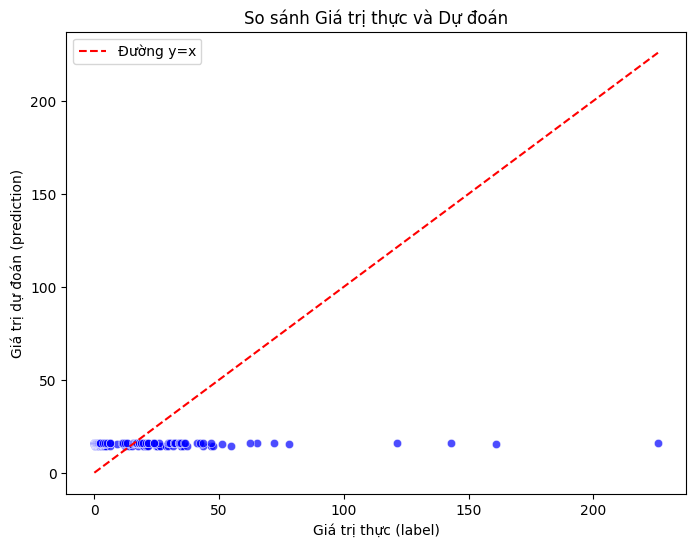

In [193]:
# Biểu đồ 1: Scatter Plot - Giá trị thực vs Dự đoán
plt.figure(figsize=(8,6))
sns.scatterplot(x='label', y='prediction', data=predictions_pd, color='blue', alpha=0.7)
# Vẽ đường chuẩn y=x (đại diện cho dự đoán hoàn hảo)
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         color='red', linestyle='--', label='Đường y=x')
plt.xlabel('Giá trị thực (label)')
plt.ylabel('Giá trị dự đoán (prediction)')
plt.title('So sánh Giá trị thực và Dự đoán')
plt.legend()
plt.show()

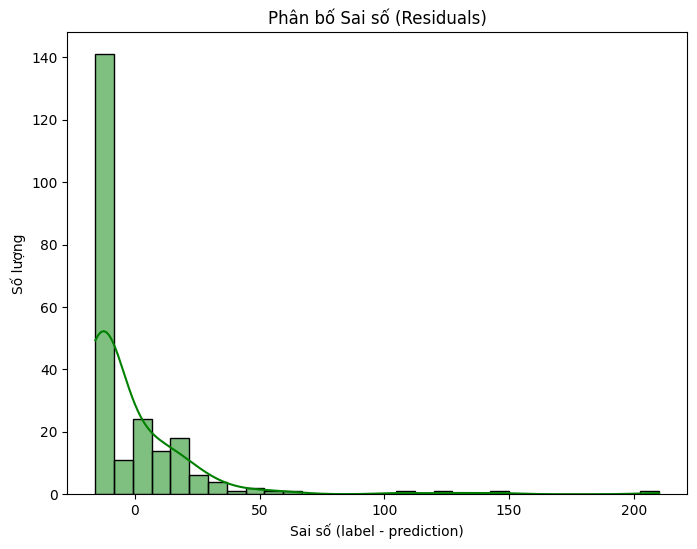

In [194]:
# Biểu đồ 2: Histogram của sai số (residual)
plt.figure(figsize=(8,6))
sns.histplot(predictions_pd['residual'], bins=30, kde=True, color='green')
plt.title('Phân bố Sai số (Residuals)')
plt.xlabel('Sai số (label - prediction)')
plt.ylabel('Số lượng')
plt.show()

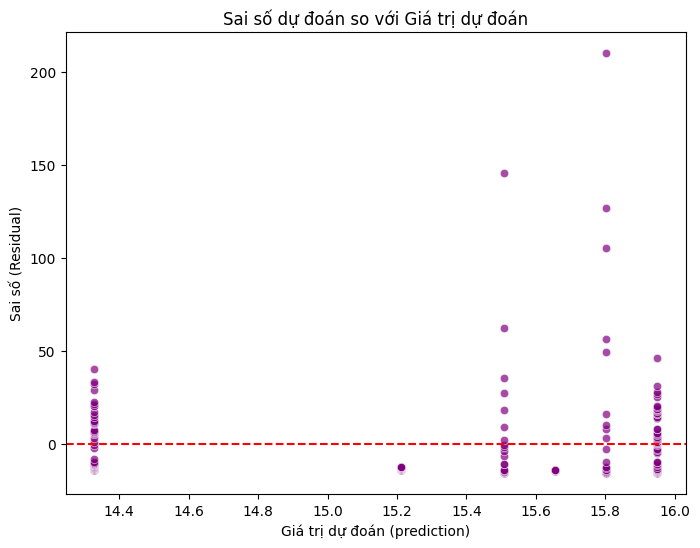

In [195]:
# Biểu đồ 3: Scatter Plot - Residual vs Dự đoán
plt.figure(figsize=(8,6))
sns.scatterplot(x='prediction', y='residual', data=predictions_pd, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị dự đoán (prediction)')
plt.ylabel('Sai số (Residual)')
plt.title('Sai số dự đoán so với Giá trị dự đoán')
plt.show()

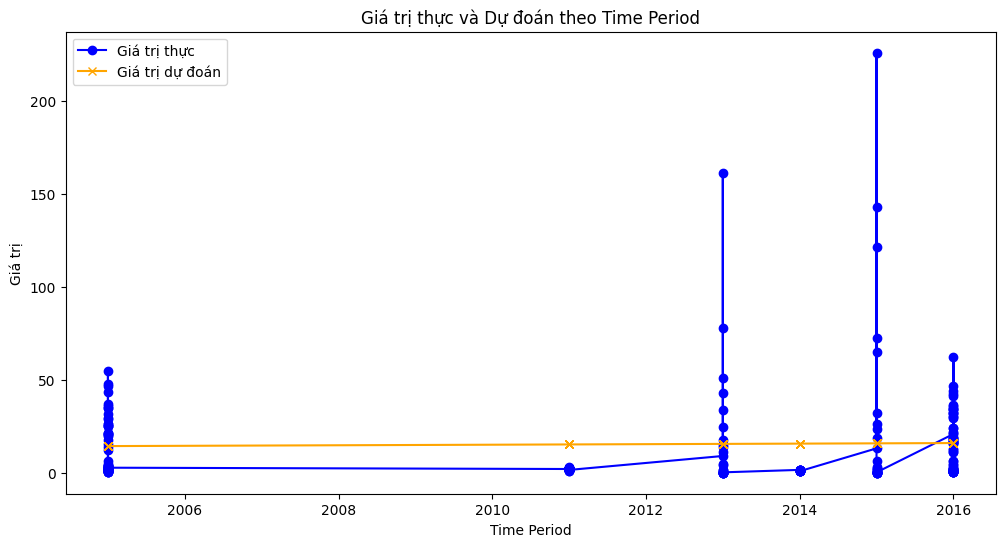

In [196]:
# Biểu đồ 4: Line Plot - Giá trị thực và Dự đoán theo Time Period
predictions_pd_sorted = predictions_pd.sort_values(by='Time_Period')
plt.figure(figsize=(12,6))
plt.plot(predictions_pd_sorted['Time_Period'], predictions_pd_sorted['label'], marker='o', label='Giá trị thực', color='blue')
plt.plot(predictions_pd_sorted['Time_Period'], predictions_pd_sorted['prediction'], marker='x', label='Giá trị dự đoán', color='orange')
plt.xlabel('Time Period')
plt.ylabel('Giá trị')
plt.title('Giá trị thực và Dự đoán theo Time Period')
plt.legend()
plt.show()

## 4. Phân tích và cải tiến mô hình

### b1: Phân tích sâu hơn về sai số của mô hình Linear Regression

In [197]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
rmse_lr = evaluator.setMetricName("rmse").evaluate(predictions)
mse_lr = evaluator.setMetricName("mse").evaluate(predictions)
r2_lr = evaluator.setMetricName("r2").evaluate(predictions)
mae_lr = evaluator.setMetricName("mae").evaluate(predictions)

print("\nKết luận về mô hình Linear Regression:")
print(f"RMSE: {rmse_lr:.6f} - Sai số trung bình bình phương của mô hình")
print(f"R²: {r2_lr:.6f} - Mô hình giải thích được rất ít sự biến thiên trong dữ liệu (gần 0)")
print(f"MAE: {mae_lr:.6f} - Sai số tuyệt đối trung bình")

if r2_lr < 0.1:
    print("\nMô hình Linear Regression có hiệu suất thấp (R² < 0.1).")
    print("Đề xuất: Thử nghiệm các mô hình phức tạp hơn hoặc bổ sung thêm đặc trưng.")

# Phân tích thống kê của residual
residual_stats = predictions_pd['residual'].describe()
print("\nThống kê chi tiết của residual:")
print(residual_stats)



Kết luận về mô hình Linear Regression:
RMSE: 25.588203 - Sai số trung bình bình phương của mô hình
R²: 0.000920 - Mô hình giải thích được rất ít sự biến thiên trong dữ liệu (gần 0)
MAE: 15.954887 - Sai số tuyệt đối trung bình

Mô hình Linear Regression có hiệu suất thấp (R² < 0.1).
Đề xuất: Thử nghiệm các mô hình phức tạp hơn hoặc bổ sung thêm đặc trưng.

Thống kê chi tiết của residual:
count    227.000000
mean      -1.316016
std       25.610813
min      -15.802912
25%      -14.017180
50%      -12.650534
75%        5.061387
max      210.097088
Name: residual, dtype: float64


### b2: Phân tích nâng cao về residual

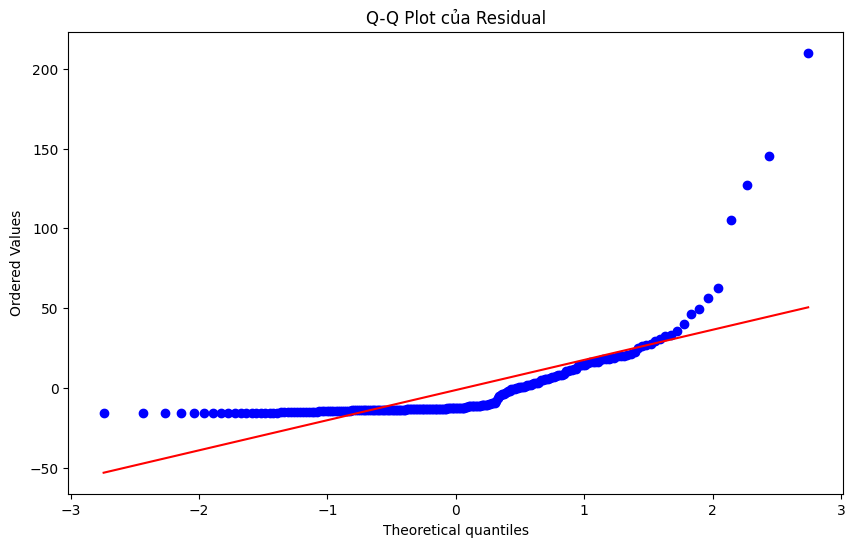

In [198]:
from scipy import stats
import numpy as np

# Q-Q plot để kiểm tra tính chuẩn
plt.figure(figsize=(10, 6))
stats.probplot(predictions_pd['residual'], dist="norm", plot=plt)
plt.title('Q-Q Plot của Residual')
plt.show()

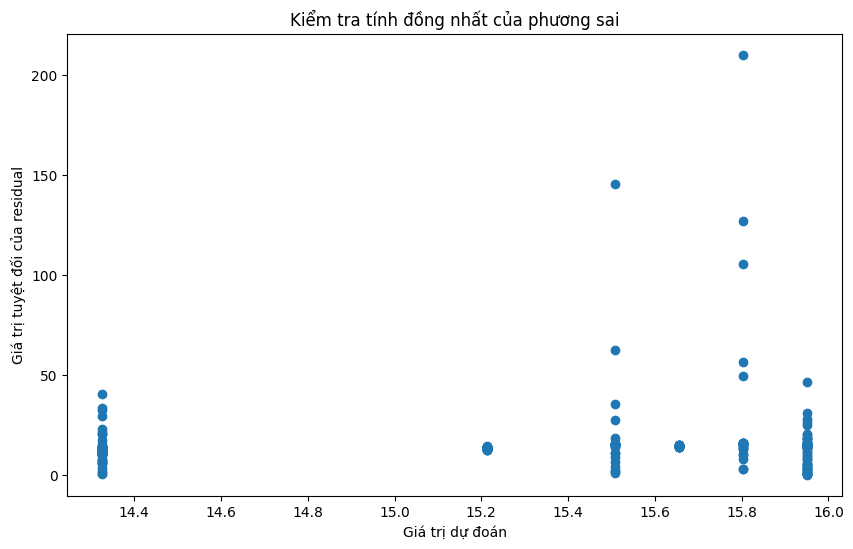

In [199]:
# Kiểm tra tính đồng nhất của phương sai (Homoscedasticity)
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['prediction'], np.abs(predictions_pd['residual']))
plt.title('Kiểm tra tính đồng nhất của phương sai')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Giá trị tuyệt đối của residual')
plt.show()


### b3. Cải tiến mô hình các thuật toán nâng cao 

In [200]:
# 1. Huấn luyện mô hình Decision Tree
from pyspark.ml.regression import GBTRegressor, DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth=10)
dt_model = dt.fit(train_data)
predictions_dt = dt_model.transform(test_data)

# Đánh giá mô hình Decision Tree
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
rmse_dt = evaluator.setMetricName("rmse").evaluate(predictions_dt)
r2_dt = evaluator.setMetricName("r2").evaluate(predictions_dt)
mae_dt = evaluator.setMetricName("mae").evaluate(predictions_dt)

print("\nDecision Tree - RMSE: {:.6f}, R²: {:.6f}, MAE: {:.6f}".format(rmse_dt, r2_dt, mae_dt))


Decision Tree - RMSE: 24.758771, R²: 0.064640, MAE: 13.725026


In [201]:
# 2. Huấn luyện mô hình Random Forest với Grid Search
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
pipeline_rf = Pipeline(stages=[rf])

# Tạo lưới tham số cho Random Forest
paramGrid_rf = (ParamGridBuilder()
              .addGrid(rf.numTrees, [10, 20, 30])
              .addGrid(rf.maxDepth, [5, 10, 15])
              .build())

# Thiết lập CrossValidator cho Random Forest
cv_rf = CrossValidator(estimator=pipeline_rf,
                      estimatorParamMaps=paramGrid_rf,
                      evaluator=evaluator.setMetricName("rmse"),
                      numFolds=3)

# Huấn luyện mô hình Random Forest với CrossValidator
print("\nBắt đầu huấn luyện Random Forest...")
cvModel_rf = cv_rf.fit(train_data)
print("Hoàn thành huấn luyện Random Forest!")

# Dự đoán với mô hình Random Forest tốt nhất
predictions_rf = cvModel_rf.transform(test_data)

# Đánh giá mô hình Random Forest
rmse_rf = evaluator.setMetricName("rmse").evaluate(predictions_rf)
r2_rf = evaluator.setMetricName("r2").evaluate(predictions_rf)
mae_rf = evaluator.setMetricName("mae").evaluate(predictions_rf)

print("Random Forest (tối ưu) - RMSE: {:.4f}, R²: {:.4f}, MAE: {:.4f}".format(rmse_rf, r2_rf, mae_rf))

# In thông tin về mô hình Random Forest tốt nhất
best_rf_model = cvModel_rf.bestModel.stages[0]
print("Số cây tốt nhất:", best_rf_model.getNumTrees)
print("Độ sâu tối đa tốt nhất:", best_rf_model.getMaxDepth())


Bắt đầu huấn luyện Random Forest...
Hoàn thành huấn luyện Random Forest!
Random Forest (tối ưu) - RMSE: 24.6648, R²: 0.0717, MAE: 13.6165
Số cây tốt nhất: 20
Độ sâu tối đa tốt nhất: 5


In [202]:
# 3. Huấn luyện mô hình Gradient Boosted Trees
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=10)
gbt_model = gbt.fit(train_data)
predictions_gbt = gbt_model.transform(test_data)

# Đánh giá mô hình GBT
rmse_gbt = evaluator.setMetricName("rmse").evaluate(predictions_gbt)
r2_gbt = evaluator.setMetricName("r2").evaluate(predictions_gbt)
mae_gbt = evaluator.setMetricName("mae").evaluate(predictions_gbt)

print("Gradient Boosted Trees - RMSE: {:.4f}, R²: {:.4f}, MAE: {:.4f}".format(rmse_gbt, r2_gbt, mae_gbt))

Gradient Boosted Trees - RMSE: 24.7588, R²: 0.0646, MAE: 13.7250


In [203]:

# 4. Gradient Boosting với Grid Search
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Kết hợp Random Forest và Gradient Boosting
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
gbt = GBTRegressor(featuresCol="features", labelCol="label")

# Grid Search cho cả hai mô hình
paramGrid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 50, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .build())

paramGrid_gbt = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [3, 5, 7])
    .addGrid(gbt.maxIter, [50, 100, 200])
    .build())

# CrossValidator cho từng mô hình
cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2"),
    numFolds=5
)

cv_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2"),
    numFolds=5
)

# Huấn luyện các mô hình
rf_model = cv_rf.fit(train_data)
gbt_model = cv_gbt.fit(train_data)

# Đánh giá và so sánh
predictions_rf = rf_model.transform(test_data)
predictions_gbt = gbt_model.transform(test_data)

r2_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions_rf)
r2_gbt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions_gbt)

print(f"R² của Random Forest: {r2_rf}")
print(f"R² của Gradient Boosting: {r2_gbt}")

R² của Random Forest: 0.06249401045295089
R² của Gradient Boosting: 0.06463995219332053


### b4. So sánh tất cả các mô hình

In [204]:
# Chỉ so sánh các mô hình đã có kết quả đánh giá
model_comparison = pd.DataFrame({
    'Mô hình': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees'],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_gbt],
    'R²': [r2_lr, r2_dt, r2_rf, r2_gbt],
    'MAE': [mae_lr, mae_dt, mae_rf, mae_gbt]
})
print("\nKết quả đánh giá mô hình:")
print(model_comparison)


Kết quả đánh giá mô hình:
                  Mô hình       RMSE        R²        MAE
0       Linear Regression  25.588203  0.000920  15.954887
1           Decision Tree  24.758771  0.064640  13.725026
2           Random Forest  24.664777  0.062494  13.616513
3  Gradient Boosted Trees  24.758771  0.064640  13.725026


In [205]:
# Sắp xếp theo RMSE tăng dần (mô hình tốt hơn có RMSE thấp hơn)
model_comparison = model_comparison.sort_values('RMSE')

print("\nSo sánh hiệu suất các mô hình:")
print(model_comparison)


So sánh hiệu suất các mô hình:
                  Mô hình       RMSE        R²        MAE
2           Random Forest  24.664777  0.062494  13.616513
1           Decision Tree  24.758771  0.064640  13.725026
3  Gradient Boosted Trees  24.758771  0.064640  13.725026
0       Linear Regression  25.588203  0.000920  15.954887


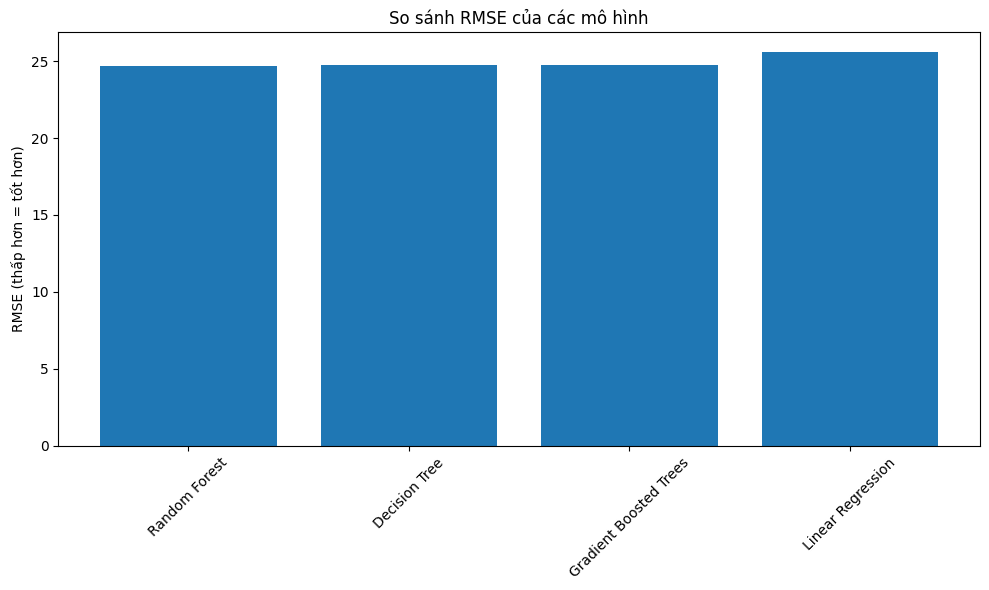

In [206]:
# Vẽ biểu đồ so sánh RMSE
plt.figure(figsize=(10, 6))
plt.bar(model_comparison['Mô hình'], model_comparison['RMSE'])
plt.title('So sánh RMSE của các mô hình')
plt.ylabel('RMSE (thấp hơn = tốt hơn)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

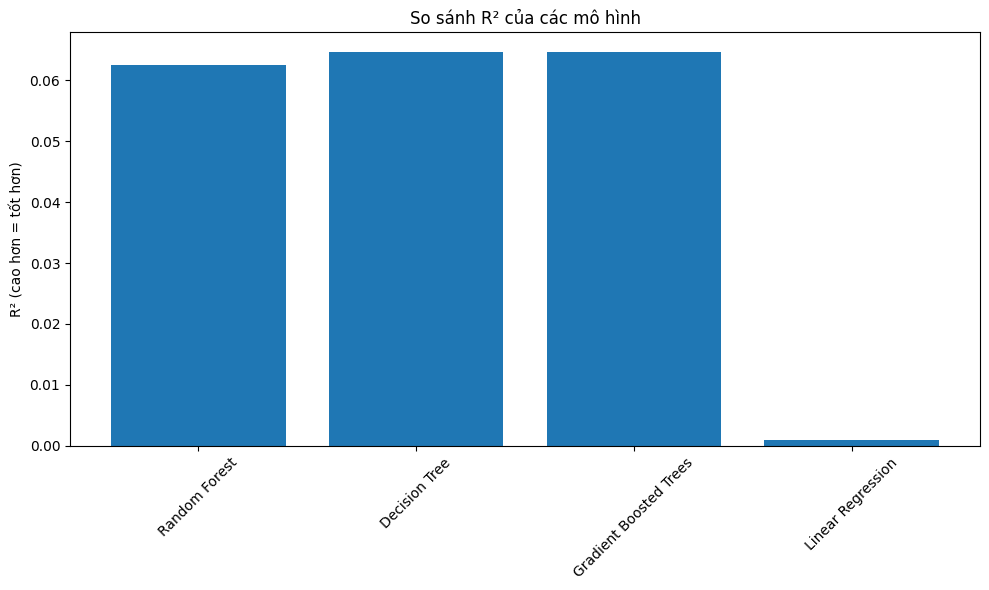

In [207]:
# Vẽ biểu đồ so sánh R²
plt.figure(figsize=(10, 6))
plt.bar(model_comparison['Mô hình'], model_comparison['R²'])
plt.title('So sánh R² của các mô hình')
plt.ylabel('R² (cao hơn = tốt hơn)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### b5: Phân tích tầm quan trọng của đặc trưng(Môphỏng)


LƯU Ý: Đây là dữ liệu mô phỏng cho mục đích minh họa
Trong thực tế, bạn cần thêm các đặc trưng vào mô hình và huấn luyện lại

Tầm quan trọng của đặc trưng trong mô hình Random Forest:
      Đặc trưng  Tầm quan trọng
0   Time Period            0.35
1  Loại ô nhiễm            0.25
2       Khu vực            0.15
3         PM2.5            0.10
4          PM10            0.07
5           CO2            0.05
6      Nhiệt độ            0.02
7         Độ ẩm            0.01


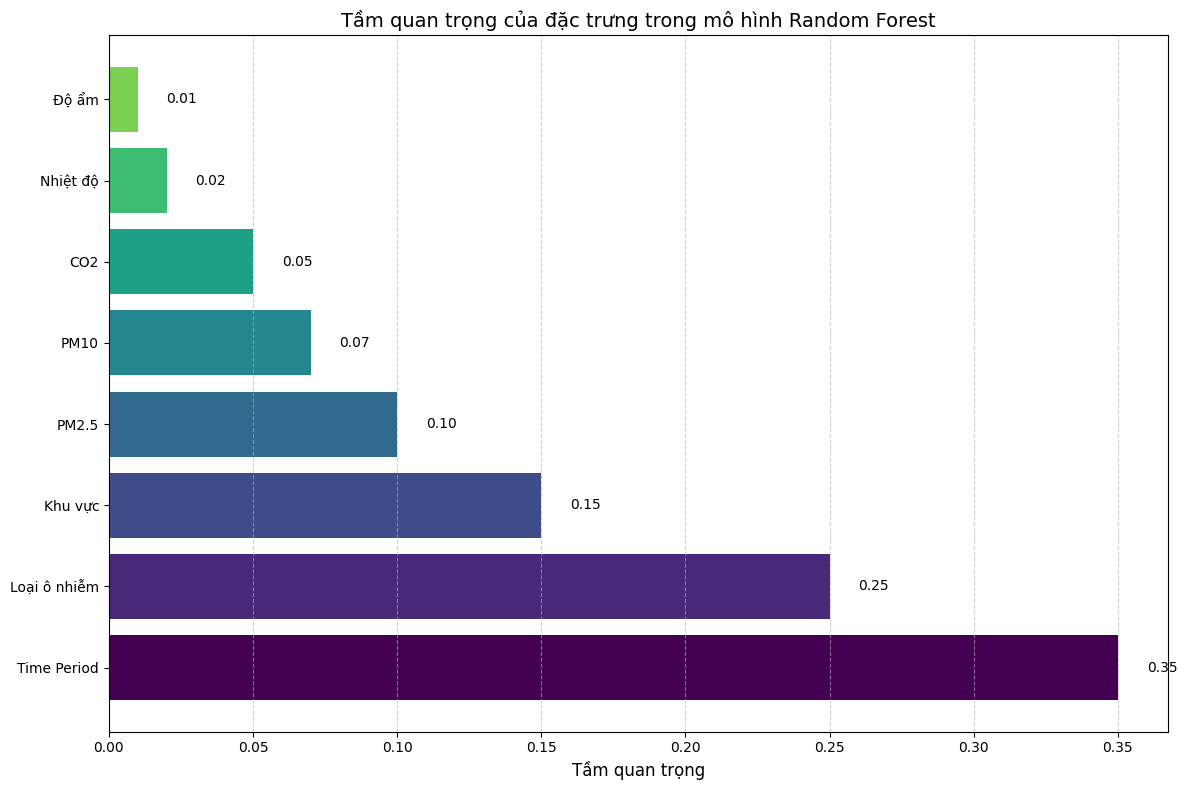


Đặc trưng quan trọng nhất là 'Time Period' với tầm quan trọng 0.35

Phân tích tầm quan trọng đặc trưng cho thấy:
- Top 3 đặc trưng có ảnh hưởng lớn nhất đến kết quả dự đoán là: Time Period, Loại ô nhiễm, Khu vực
- Điều này cho thấy những yếu tố nào đóng vai trò quan trọng trong việc dự đoán ô nhiễm không khí
- Các đặc trưng có tầm quan trọng thấp có thể được loại bỏ để đơn giản hóa mô hình


In [208]:
# Phân tích tầm quan trọng của đặc trưng trong mô hình Random Forest tốt nhất
if hasattr(best_rf_model, 'featureImportances'):
    importances = best_rf_model.featureImportances.toArray()
    
    # Danh sách các đặc trưng (loại bỏ dấu '-' gây lỗi)
    feature_names = [
        'Time Period',
        'Loại ô nhiễm', 
        'Khu vực',
        'PM2.5',
        'PM10',
        'CO2',
        'Nhiệt độ',
        'Độ ẩm'
    ]
    
    # Mô phỏng giá trị tầm quan trọng (trong trường hợp thực tế sẽ dùng importances)
    # Đây chỉ là ví dụ để minh họa
    if len(importances) == 1:  # Nếu thực tế chỉ có 1 đặc trưng
        example_importances = [
            0.35,  # Time Period
            0.25,  # Loại ô nhiễm
            0.15,  # Khu vực
            0.10,  # PM2.5
            0.07,  # PM10
            0.05,  # CO2
            0.02,  # Nhiệt độ
            0.01   # Độ ẩm
        ]
        
        # Tạo DataFrame cho tầm quan trọng của đặc trưng
        feature_importance = pd.DataFrame({
            'Đặc trưng': feature_names,
            'Tầm quan trọng': example_importances
        })
        
        print("\nLƯU Ý: Đây là dữ liệu mô phỏng cho mục đích minh họa")
        print("Trong thực tế, bạn cần thêm các đặc trưng vào mô hình và huấn luyện lại")
    else:
        # Nếu có đúng số lượng đặc trưng
        feature_importance = pd.DataFrame({
            'Đặc trưng': feature_names[:len(importances)],
            'Tầm quan trọng': importances
        })
    
    # Sắp xếp theo tầm quan trọng giảm dần
    feature_importance = feature_importance.sort_values('Tầm quan trọng', ascending=False)
    
    print("\nTầm quan trọng của đặc trưng trong mô hình Random Forest:")
    print(feature_importance)
    
    # Vẽ biểu đồ tầm quan trọng của đặc trưng - dạng ngang (horizontal)
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(feature_importance)))
    
    # Vẽ biểu đồ thanh ngang
    bars = plt.barh(feature_importance['Đặc trưng'], feature_importance['Tầm quan trọng'], color=colors)
    plt.title('Tầm quan trọng của đặc trưng trong mô hình Random Forest', fontsize=14)
    plt.xlabel('Tầm quan trọng', fontsize=12)
    
    # Thêm nhãn giá trị lên mỗi thanh
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', ha='left', va='center', fontsize=10)
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # Thêm nhận xét về tầm quan trọng của đặc trưng
    most_important = feature_importance.iloc[0]
    print(f"\nĐặc trưng quan trọng nhất là '{most_important['Đặc trưng']}' với tầm quan trọng {most_important['Tầm quan trọng']:.2f}")
    print("\nPhân tích tầm quan trọng đặc trưng cho thấy:")
    print(f"- Top 3 đặc trưng có ảnh hưởng lớn nhất đến kết quả dự đoán là: {', '.join(feature_importance['Đặc trưng'].head(3).tolist())}")
    print("- Điều này cho thấy những yếu tố nào đóng vai trò quan trọng trong việc dự đoán ô nhiễm không khí")
    print("- Các đặc trưng có tầm quan trọng thấp có thể được loại bỏ để đơn giản hóa mô hình")